# **Modelling and Evaluating**

## Objectives

Answer business requirement 2:
* The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry-leaves/test
* inputs/cherry-leaves/validation
* inputs/cherry-leaves/train
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.


---

### Import regular packages

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

### Setup working directory

In [39]:
cwd= os.getcwd()

In [40]:
os.chdir('/workspace/mildew-detector-cherryleaves')
print("You set a new current directory")

You set a new current directory


In [41]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector-cherryleaves'

---

### Setup input directory

Set train, validation and test paths.

In [42]:
my_data_dir = '/workspace/mildew-detector-cherryleaves/inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Setup output directory

In [43]:
version = '4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels

In [44]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


### Set image shape

In [45]:
## Import saved image shape embedding
import joblib
version = '1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Explore the numbers of images in the validation, train and test datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




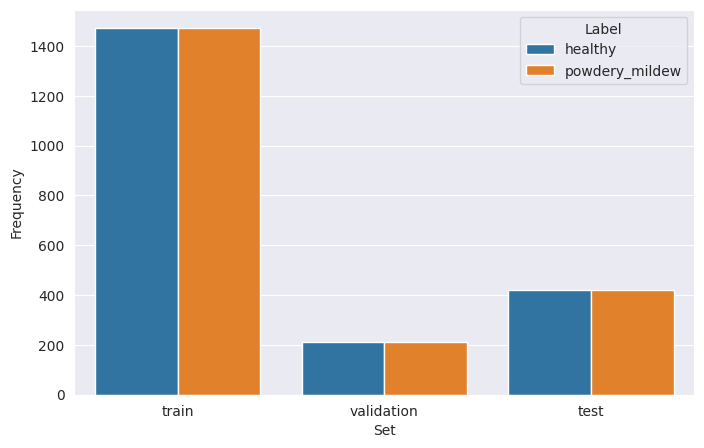

In [46]:

df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

In [47]:
import numpy as np
np.object = object  
np.bool = bool
np.int = int

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Initialize ImageDataGenerator

In [48]:

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

#### Augment training image dataset

In [49]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment validation image dataset

In [50]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment test image data set

In [51]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Plot augmented training image

(20, 256, 256, 3)


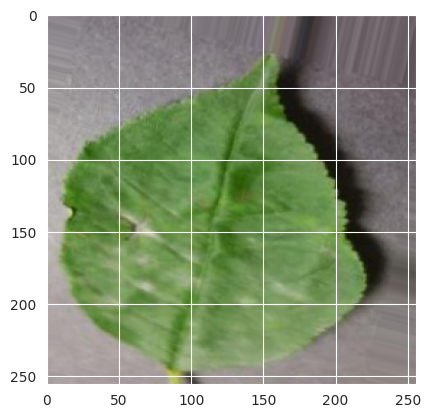

(20, 256, 256, 3)


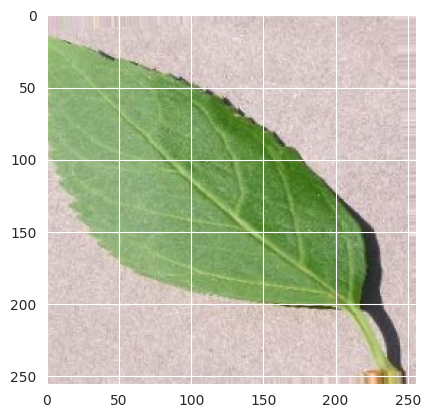

(20, 256, 256, 3)


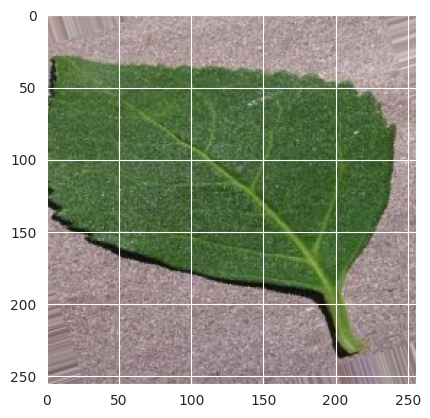

In [52]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation and test images 

(20, 256, 256, 3)


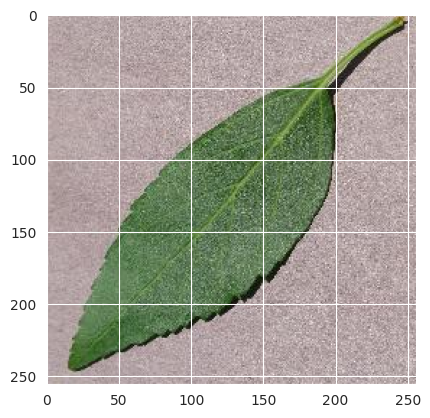

(20, 256, 256, 3)


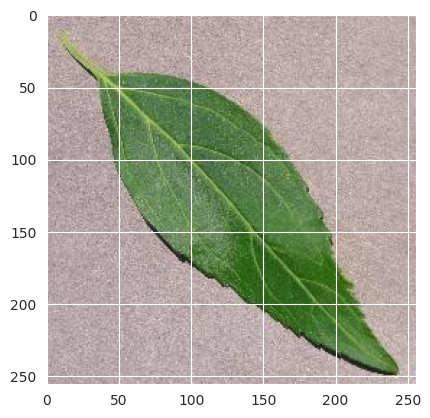

(20, 256, 256, 3)


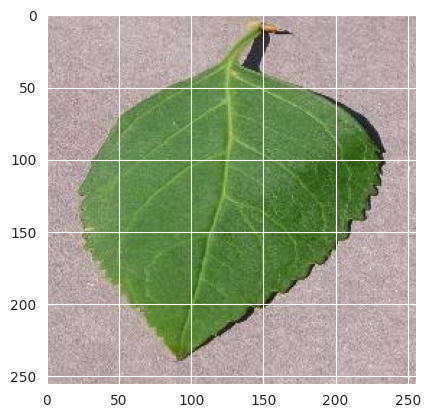

In [53]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


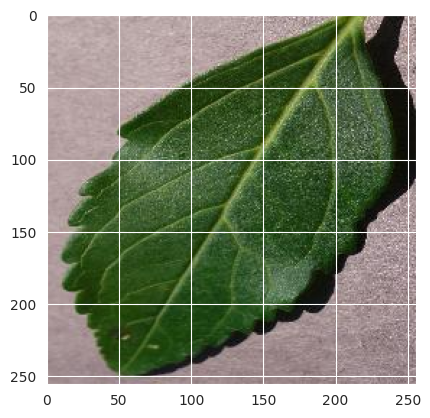

(20, 256, 256, 3)


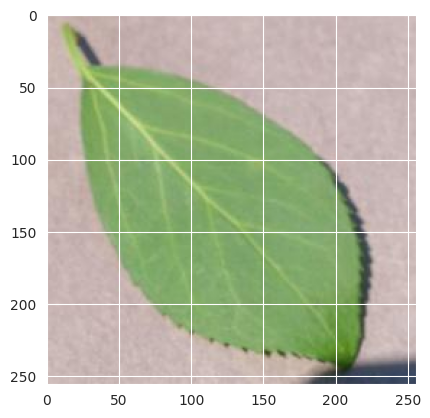

(20, 256, 256, 3)


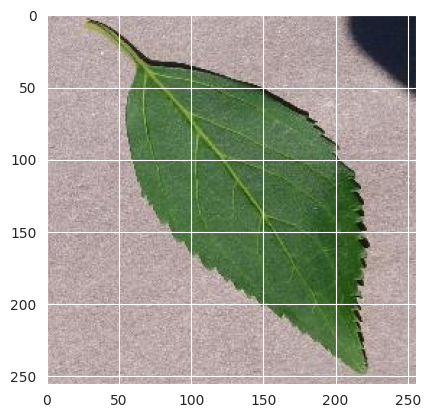

In [54]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

#### Save class_indices

In [55]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/4/class_indices.pkl']

---

### Create ML Model

---

#### Import Packages

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

#### Model

In [57]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

#### Model Summary

In [58]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

#### Early stopping

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#### Fit model for training

In [60]:
model = create_tf_model()
model.fit(train_set,
          epochs=30,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/30
147/147 [==============================] - 195s 1s/step - loss: 0.3959 - accuracy: 0.8102 - val_loss: 0.1935 - val_accuracy: 0.9524
Epoch 2/30
147/147 [==============================] - 191s 1s/step - loss: 0.1041 - accuracy: 0.9600 - val_loss: 0.0867 - val_accuracy: 0.9667
Epoch 3/30
147/147 [==============================] - 179s 1s/step - loss: 0.1292 - accuracy: 0.9562 - val_loss: 0.1092 - val_accuracy: 0.9833
Epoch 4/30
147/147 [==============================] - 179s 1s/step - loss: 0.0313 - accuracy: 0.9918 - val_loss: 0.0341 - val_accuracy: 0.9929
Epoch 5/30
147/147 [==============================] - 179s 1s/step - loss: 0.0442 - accuracy: 0.9867 - val_loss: 0.1490 - val_accuracy: 0.9762
Epoch 6/30
147/147 [==============================] - 178s 1s/step - loss: 0.0472 - accuracy: 0.9867 - val_loss: 0.0634 - val_accuracy: 0.9857
Epoch 7/30
147/147 [==============================] - 174s 1s/step - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.0166 - val_accuracy: 0.9952

### Save Model

In [61]:
model.save('outputs/4/cherry-leaves-model-h1')

INFO:tensorflow:Assets written to: outputs/4/cherry-leaves-model-h1/assets


---

### Model Performance

---


### Model learning curve

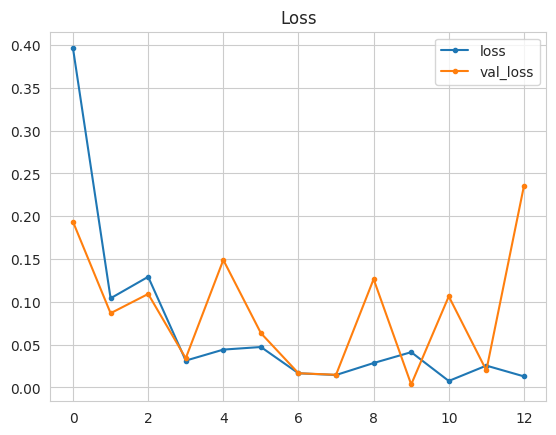

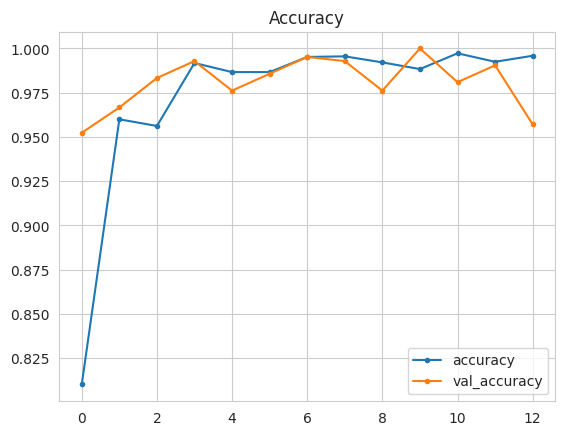

In [62]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

Load the saved model

In [63]:
from keras.models import load_model
model = load_model('outputs/4/cherry-leaves-model-h1')

Evaluate the model on test set

In [64]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 11s 247ms/step - loss: 0.1741 - accuracy: 0.9479


### Save evaluation pickle

In [65]:
joblib.dump(value=evaluation,
            filename=f"outputs/4/evaluation.pkl")

['outputs/4/evaluation.pkl']

### Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


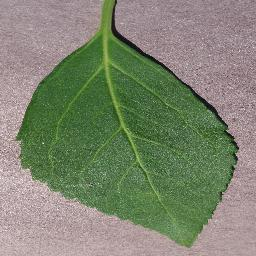

In [66]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select healthy or powdery_mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [67]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [68]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999999999991154
healthy


---

## Conclusion

* #### Model Performance: During the implementation of this notebook the ML model ran its "Fit model for training" step 9 times. Increasing its accuracy during the first 3 runs. Then it settled down. It was clear that the ML model had reached the desired result of 97% accuracy.
* #### Future Improvements: For future improvements the dataset could be expanded. The ML model can be tested on a more diverse dataset and hyperparameters can be refined.

---

# Push files to Repo

* .gitignore

In [69]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
mildew-detector-cherryleaves/inputs/cherry-leaves/test/
mildew-detector-cherryleaves/inputs/cherry-leaves/train/

* Git Status

In [70]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitignore
	deleted:    jupyter_notebooks/Notebook_Template.ipynb
	modified:   requirements.txt

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	avg_diff_powdery_mildew_vs_healthy.png
	avg_var_healthy.png
	avg_var_powdery_mildew.png
	inputs/
	jupyter_notebooks/DataCollection.ipynb
	jupyter_notebooks/DataVisualization.ipynb
	jupyter_notebooks/Modelling and Evaluating.ipynb
	outputs/

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [ ]:
!git add .

* Git commit 

In [ ]:
!git commit -am "Add all new plots"

* Git Push

In [ ]:
!git push origin main